# Tracking a 1d pendulum using Extended / Unscented Kalman filter/ smoother

This notebook demonstrates a simple pendulum tracking example.
The example is taken from p45 of 
*Bayesian Filtering and Smoothing* (S. Särkkä, 2013).
This code is based on the  [sarkka-jax](https://github.com/petergchang/sarkka-jax) repo.


The physics of the problem is shown below, where $\alpha$ is the angle relative to vertical,
and $w(t)$ is a white noise process added to the angular velocity (a random acceleration term).

![Pendulum](https://github.com/probml/dynamax/blob/main/docs/figures/pendulum.png?raw=true)

This gives rise to the following differential equation:
\begin{align*}
\frac{d^2 \alpha}{d t^2}
= -g \sin(\alpha) + w(t)
\end{align*}
We can write this as a nonlinear SSM by defining the state to be
$z_1(t) = \alpha(t)$ and $z_2(t) = d\alpha(t)/dt$.
Thus

\begin{align*}
\frac{d z}{dt}
= \begin{pmatrix} z_2 \\ -g \sin(z_1) \end{pmatrix}
+ \begin{pmatrix} 0 \\ 1 \end{pmatrix} w(t)
\end{align*}

If we discretize this step size $\Delta$,
we get the following formulation:

\begin{align*}
  \begin{pmatrix} z_{1,t} \\ z_{2,t} \end{pmatrix}
=
  \begin{pmatrix} z_{1,t-1} + z_{2,t-1} \Delta  \\
    z_{2,t-1} -g \sin(z_{1,t-1}) \Delta 
     \end{pmatrix}
+q_{t} 
\end{align*}






where $q_t \sim N(0,Q)$, and

\begin{equation*}
Q = q^c
\begin{pmatrix}
  \frac{\Delta^3}{3} &   \frac{\Delta^2}{2} \\
  \frac{\Delta^2}{2} & \Delta 
  \end{pmatrix} 
\end{equation*}


where $q^c$ is the spectral density 
of the continuous-time noise process.

We assume the observation model is

\begin{align*}
y_t &= h(z_t) + r_t \\
h(z_t) &=  \sin(\alpha_t)  = \sin(z_{t,1}) \\
r_t &\sim N(0,R)
\end{align*}


Here, we show that running for 10x longer time (than the original notebook) exhibits unbounded growth of the solution. This occurs with $q_c=1$ and $q_c=1e-10$. If you play with things, you will see that even with \~0 dynamics noise, the pendulum oscillates back and forth for a few time units, then starts doing full rotations (a non-physical result that breaks conservation of energy). Reducing the integration time-step increases the time horizon for which the dynamics are stable, but the numerical solution still eventually leaves the attractor. Symplectic integrators avoid this issue by preserving energy in deterministic Hamiltonian systems. For stochastic Hamiltonian systems (i.e., the deterministic physics obey conservation of energy, but energy is randomly introduced via stochastic forcing), one can use even more specialized integrators (see http://umu.diva-portal.org/smash/get/diva2:1391559/FULLTEXT01.pdf and https://mathweb.ucsd.edu/~j2schmit/stochasticVI.pdf). The goal of these stochastic symplectic integrators is to ensure that energy drifts only linearly (in line with what is expected from the stochastic forcings).

Nevertheless, the filters perform well in their tracking tasks.

## Setup

In [1]:
import sys
%matplotlib inline
sys.path.append("../../..")
sys.path.append("../..")

import dynamax

import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as jr
from jax import lax
from jaxtyping import Float, Array
from typing import Callable, NamedTuple

from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_smoother, unscented_kalman_smoother

In [2]:
# For pretty print of ndarrays
jnp.set_printoptions(formatter={"float_kind": "{:.2f}".format})

## Sample data and plot it

In [3]:
# Some parameters
dt = 0.0125
g = 9.8
q_c = 1 #, 1e-10...toggle this to see the effect of process noise
r = 0.3

# Lightweight container for pendulum parameters
class PendulumParams(NamedTuple):
    initial_state: Float[Array, "state_dim"] = jnp.array([jnp.pi / 2, 0])
    dynamics_function: Callable = lambda x: jnp.array([x[0] + x[1] * dt, x[1] - g * jnp.sin(x[0]) * dt])
    dynamics_covariance: Float[Array, "state_dim state_dim"] = jnp.array([[q_c * dt**3 / 3, q_c * dt**2 / 2], [q_c * dt**2 / 2, q_c * dt]])
    emission_function: Callable = lambda x: jnp.array([jnp.sin(x[0])])
    emission_covariance: Float[Array, "emission_dim"] = jnp.eye(1) * (r**2)

In [4]:
# Pendulum simulation (Särkkä Example 3.7)
def simulate_pendulum(params=PendulumParams(), key=0, num_steps=4000):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    # Unpack parameters
    M, N = params.initial_state.shape[0], params.emission_covariance.shape[0]
    f, h = params.dynamics_function, params.emission_function
    Q, R = params.dynamics_covariance, params.emission_covariance

    def _step(carry, rng):
        state = carry
        rng1, rng2 = jr.split(rng, 2)

        next_state = f(state) + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        obs = h(next_state) + jr.multivariate_normal(rng2, jnp.zeros(N), R)
        return next_state, (next_state, obs)

    rngs = jr.split(key, num_steps)
    _, (states, observations) = lax.scan(_step, params.initial_state, rngs)
    return states, observations


def plot_pendulum(time_grid, x_tr, x_obs, x_est=None, est_type=""):
    plt.figure()
    plt.plot(time_grid, x_tr, color="darkgray", linewidth=4, label="True Angle")
    # plt.plot(time_grid, x_obs, "ok", fillstyle="none", ms=1.5, label="Measurements")
    if x_est is not None:
        plt.plot(time_grid, x_est, color="k", linewidth=1.5, label=f"{est_type} Estimate")
    plt.xlabel("Time $t$")
    plt.ylabel("Pendulum angle $x_{1,k}$")
    # plt.xlim(0, 5)
    # plt.ylim(-3, 5)
    # plt.xticks(jnp.arange(0.5, 4.6, 0.5))
    # plt.yticks(jnp.arange(-3, 5.1, 1))
    # plt.gca().set_aspect(0.5)
    plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    plt.yscale("symlog")
    plt.show()

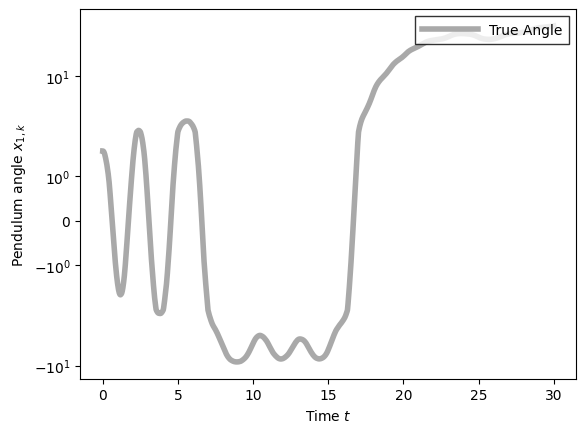

In [5]:
T = 30.0
num_steps = int(T / dt)
states, obs = simulate_pendulum(num_steps=num_steps)

# Create time grid for plotting
time_grid = jnp.arange(0.0, T, step=dt)

# Plot the generated data
plot_pendulum(time_grid, states[:, 0], obs)

In [6]:
# Compute RMSE
def compute_rmse(y, y_est):
    return jnp.sqrt(jnp.sum((y - y_est) ** 2) / len(y))


# Compute RMSE of estimate and print comparison with
# standard deviation of measurement noise
def compute_and_print_rmse_comparison(y, y_est, R, est_type=""):
    rmse_est = compute_rmse(y, y_est)
    print(f'{f"The RMSE of the {est_type} estimate is":<40}: {rmse_est:.2f}')
    print(f'{"The std of measurement noise is":<40}: {jnp.sqrt(R):.2f}')

## Extended Kalman Filter  / smoother

In [7]:
pendulum_params = PendulumParams()

# Define parameters for EKF
ekf_params = ParamsNLGSSM(
    initial_mean=pendulum_params.initial_state,
    initial_covariance=jnp.eye(states.shape[-1]) * 0.1,
    dynamics_function=pendulum_params.dynamics_function,
    dynamics_covariance=pendulum_params.dynamics_covariance,
    emission_function=pendulum_params.emission_function,
    emission_covariance=pendulum_params.emission_covariance,
)

ekf_posterior = extended_kalman_smoother(ekf_params, obs)


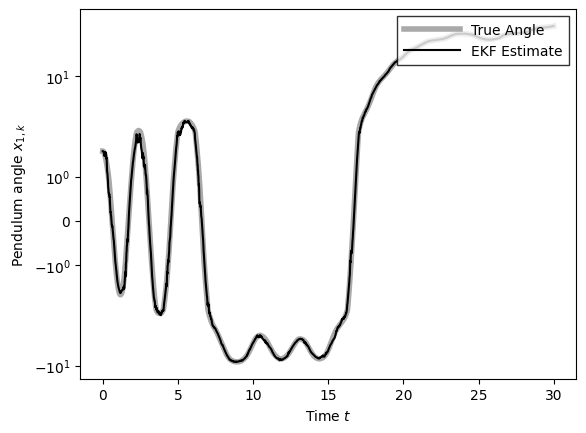

The RMSE of the EKF estimate is         : 0.15
The std of measurement noise is         : 0.55


In [8]:

m_ekf = ekf_posterior.filtered_means[:, 0]
plot_pendulum(time_grid, states[:, 0], obs, x_est=m_ekf, est_type="EKF")
compute_and_print_rmse_comparison(states[:, 0], m_ekf, r, "EKF")



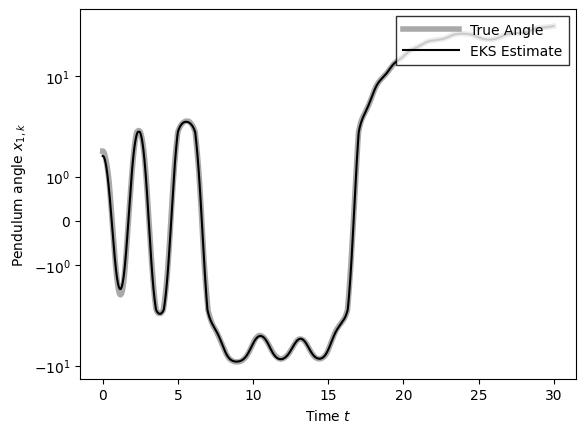

The RMSE of the EKS estimate is         : 0.07
The std of measurement noise is         : 0.55


In [9]:
m_ekf = ekf_posterior.smoothed_means[:, 0]
plot_pendulum(time_grid, states[:, 0], obs, x_est=m_ekf, est_type="EKS")
compute_and_print_rmse_comparison(states[:, 0], m_ekf, r, "EKS")

## Unscented Kalman Filter  / smoother

In [10]:
pendulum_params = PendulumParams()

ukf_params = ParamsNLGSSM(
    initial_mean=pendulum_params.initial_state,
    initial_covariance=jnp.eye(states.shape[-1]) * 0.1,
    dynamics_function=pendulum_params.dynamics_function,
    dynamics_covariance=pendulum_params.dynamics_covariance,
    emission_function=pendulum_params.emission_function,
    emission_covariance=pendulum_params.emission_covariance,
)

ukf_hyperparams = UKFHyperParams() # default gives same results as EKF


ukf_posterior = unscented_kalman_smoother(ukf_params, obs, ukf_hyperparams)

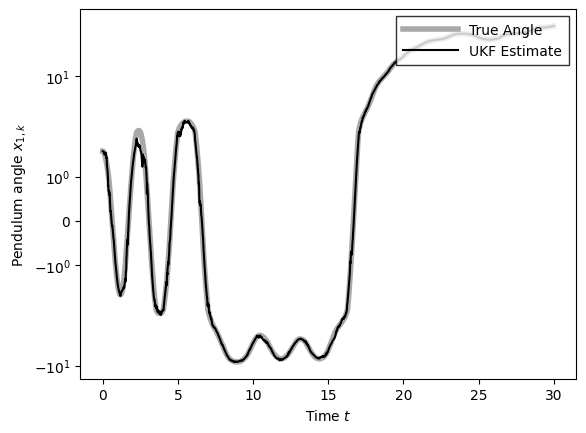

The RMSE of the UKF estimate is         : 0.15
The std of measurement noise is         : 0.55


In [11]:

m_ukf = ukf_posterior.filtered_means[:, 0]
plot_pendulum(time_grid, states[:, 0], obs, x_est=m_ukf, est_type="UKF")
compute_and_print_rmse_comparison(states[:, 0], m_ukf, r, "UKF")

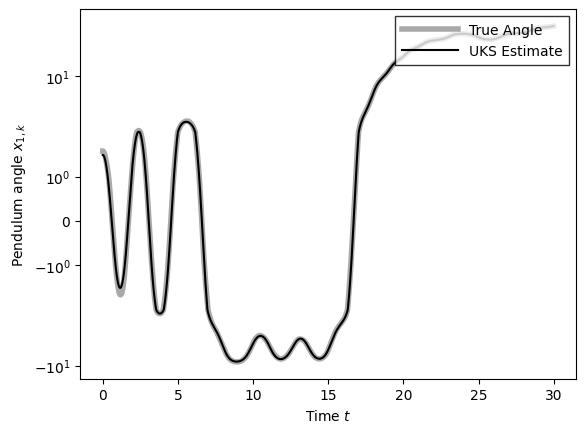

The RMSE of the UKS estimate is         : 0.07
The std of measurement noise is         : 0.55


In [12]:

m_uks = ukf_posterior.smoothed_means[:, 0]
plot_pendulum(time_grid, states[:, 0], obs, x_est=m_uks, est_type="UKS")
compute_and_print_rmse_comparison(states[:, 0], m_uks, r, "UKS")

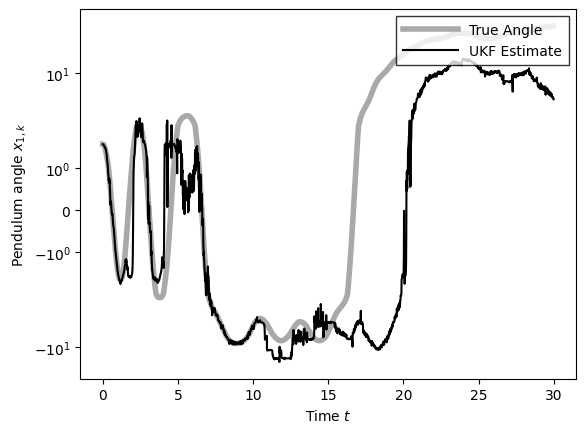

The RMSE of the UKF estimate is         : 14.54
The std of measurement noise is         : 0.55


In [13]:
# Let's see how sensitive UKF is to hyper-params

ukf_hyperparams = UKFHyperParams(alpha=3, beta=3, kappa=3)

ukf_posterior = unscented_kalman_smoother(ukf_params, obs, ukf_hyperparams)

m_ukf = ukf_posterior.filtered_means[:, 0]
plot_pendulum(time_grid, states[:, 0], obs, x_est=m_ukf, est_type="UKF")
compute_and_print_rmse_comparison(states[:, 0], m_ukf, r, "UKF")